# Preprocessing Sentinel-2 images

### Import packages

In [1]:
import glob, os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from pathlib import Path
import rasterstats
from rasterstats import zonal_stats
import datetime
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode()

print('All libraries successfully imported!')
print(f'Rasterstats : {rasterstats.__version__}')



All libraries successfully imported!
Rasterstats : 0.16.0


### Set directory

In [2]:
work_path = f'/export/homes/students/rkahn/EXPORT/'
print(work_path)
roi_path = f'{work_path}ROI/'
composite = f'{work_path}COMPOSITE/'
seasons = f'{work_path}SEASONS/'
vector_file = f'{work_path}COMPOSITE_SEGMENTED/'
segmented_path = f'{work_path}SEASONS_SEGMENTED/'
zonal_stat_path = f'{work_path}ZONAL_STATS/'
zonal_stat_csv  = f'{zonal_stat_path}zonal_stat_cont_{seasons}.csv'
zonal_stat_shp  = f'{zonal_stat_path}zonal_stat_cont_{seasons}.shp'

stat_name = 'mean'
nodata_val = -10000

/export/homes/students/rkahn/EXPORT/


### Set region of interest

In [3]:
crs = 'EPSG:32631'
roi_name     = 'extent_roi'
roi_filename = f'{roi_name}.shp'
roi_file     = f'{roi_path}{roi_filename}'
roi_gdf = gpd.read_file(roi_file)
print(f'ROI shapefile : {roi_file}')

ROI shapefile : /export/homes/students/rkahn/EXPORT/ROI/extent_roi.shp


#### Display the comoposite NDVI 2019-2021

/export/homes/students/rkahn/EXPORT/COMPOSITE/NDVI_2019_2021.tif


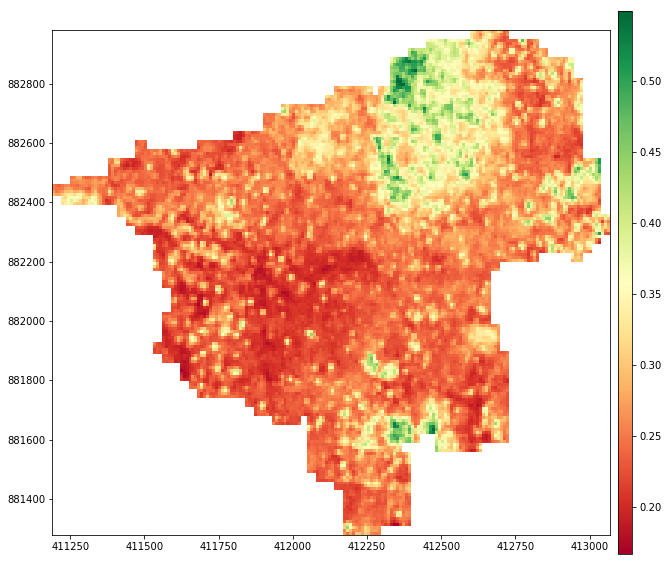

In [4]:
### Open spectral index file with rasterio
im_file = (f'{composite}NDVI_2019_2021.tif')
titles = os.path.basename(im_file)
print(im_file)
src = rasterio.open(im_file,"r")
fig, ax = plt.subplots(1, 1, figsize=(10,10))
color_map = plt.cm.get_cmap("RdYlGn")
im_rio = rasterio.plot.show(src, cmap=color_map, ax=ax) #title=(im_file) # no title for the report
im_rio = im_rio.get_images()[0]
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)
plt.savefig(f'/export/homes/students/rkahn/FIGURES/COMPOSITE/{titles}.png', format='png')
plt.box(False)


### Display all the NDVI from wet/dry seasons

/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2022_seche.tif
/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2019_humide.tif
/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2019_seche.tif
/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2020_humide.tif
/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2020_seche.tif
/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2021_humide.tif
/export/homes/students/rkahn/EXPORT/SEASONS/NDVI_2021_seche.tif


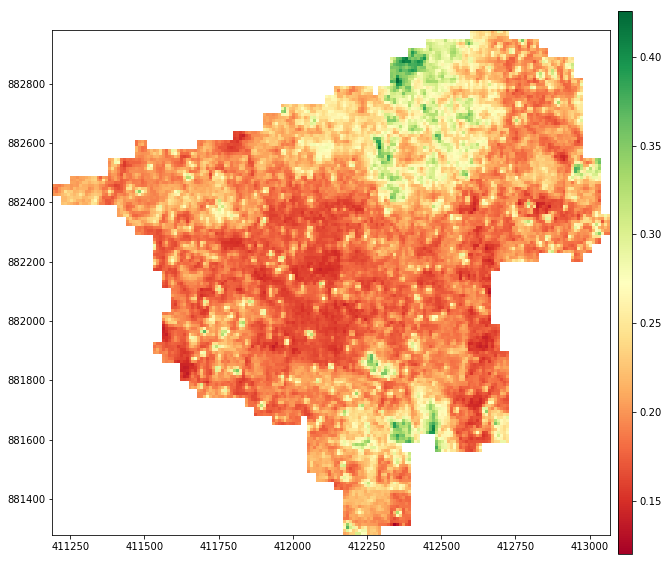

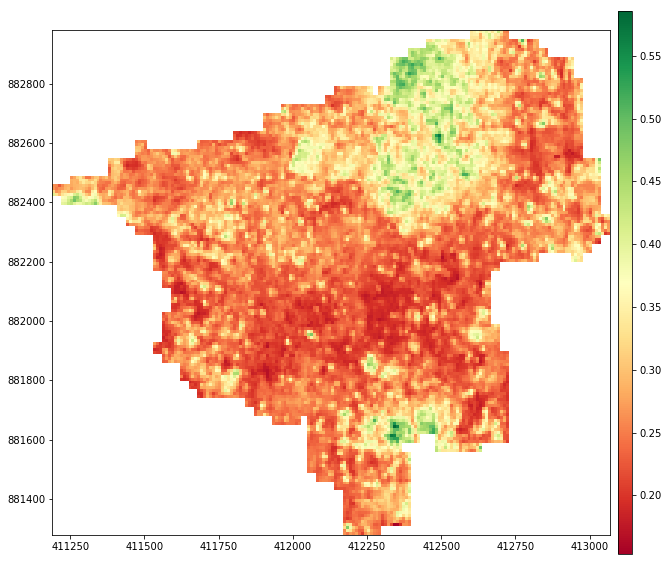

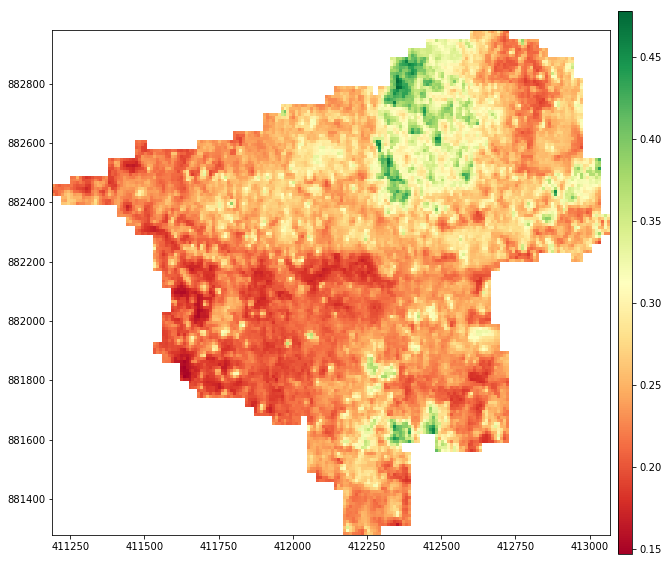

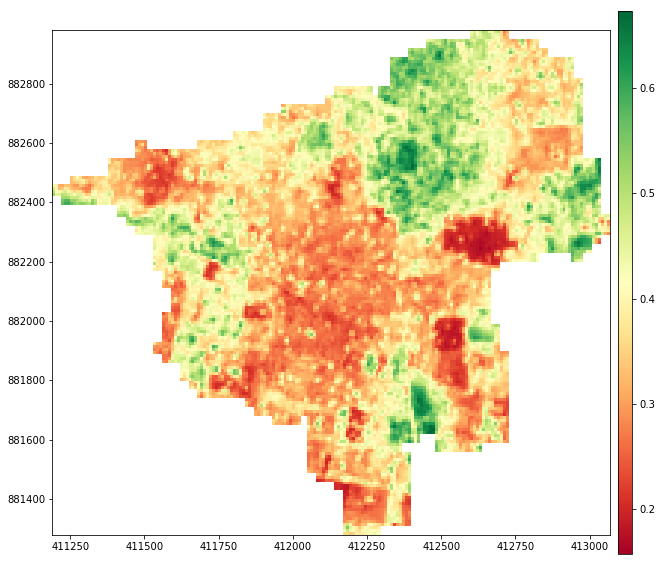

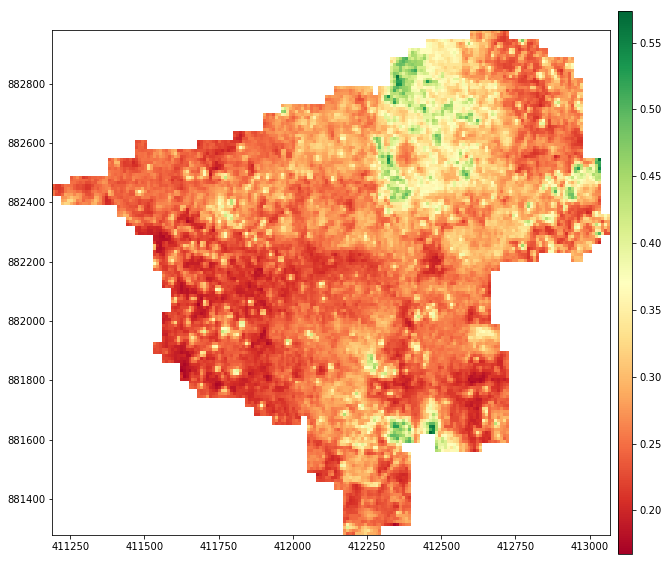

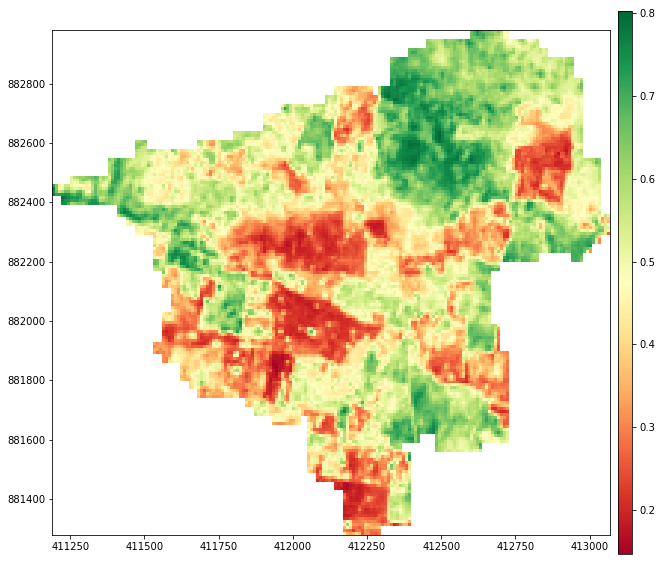

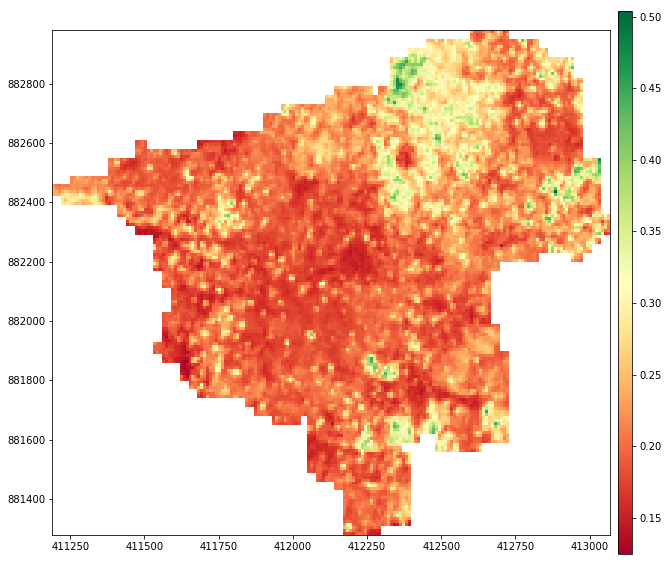

In [68]:
### Open spectral index file with rasterio  
im_file = sorted(glob.glob(f'{seasons}*.tif'))
for i in range (len(im_file)):
    im_file = glob.glob(f'{seasons}*.tif')[i]
    titles = os.path.basename(im_file)
    print(im_file)
    src = rasterio.open(im_file,"r")
    #print(src.crs)
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    color_map = plt.cm.get_cmap("RdYlGn")
    im_rio = rasterio.plot.show(src, cmap=color_map, ax=ax, #title=(im_file)[-20:-4]
    )
    #im_rio = rasterio.plot.show(src, cmap=reversed_color_map, ax=ax)
    im_rio = im_rio.get_images()[0]
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im_rio, ax=ax, cax=cax)
    plt.savefig(f'/export/homes/students/rkahn/FIGURES/SEASONS/SEASONS_NDVI{titles}.png', format='png')
    plt.box(False)
    

# Segmentation with Orfeo ToolBox

Mean-Shift
OTB implementation of the Mean-Shift algorithm (multi-threaded).

In [11]:
# Import the otb applications package
import otbApplication as otbApplication

# The following line creates an instance of the LargeScaleMeanShift application
LargeScaleMeanShift = otbApplication.Registry.CreateApplication("LargeScaleMeanShift")
im_file = glob.glob(f'{composite}*.tif')
im_sortie = [f'{vector_file}{os.path.basename(i)[:-4]}_SEGMENTED_20pix.shp' for i in im_file]
print(im_sortie)

# The following lines set all the application parameters:
for i,j in zip(im_file,im_sortie):
    print(i,j)
    LargeScaleMeanShift.SetParameterString("in", f'{i}')
    LargeScaleMeanShift.SetParameterInt("spatialr", 40)
#Spatial radius: Radius of the spatial neighborhood for averaging. 
#Higher values will result in more smoothing and higher processing time.
    LargeScaleMeanShift.SetParameterFloat("ranger", 30)
#Range radius: Threshold on spectral signature euclidean distance (expressed in radiometry unit) 
#to consider neighborhood pixel for averaging. Higher values will be less edge-preserving (more similar to simple average in neighborhood), 
#whereas lower values will result in less noise smoothing. 
#Note that this parameter has no effect on processing time.
    LargeScaleMeanShift.SetParameterInt("minsize", 50)
    LargeScaleMeanShift.SetParameterString("mode.vector.out", f'{j}')
# The following line execute the application
    LargeScaleMeanShift.ExecuteAndWriteOutput()

['/export/homes/students/rkahn/EXPORT/COMPOSITE_SEGMENTED/NDVI_seche_2019_2021_SEGMENTED_20pix.shp', '/export/homes/students/rkahn/EXPORT/COMPOSITE_SEGMENTED/NDVI_humide_2019_2021_SEGMENTED_20pix.shp', '/export/homes/students/rkahn/EXPORT/COMPOSITE_SEGMENTED/NDVI_2019_2021_SEGMENTED_20pix.shp']
/export/homes/students/rkahn/EXPORT/COMPOSITE/NDVI_seche_2019_2021.tif /export/homes/students/rkahn/EXPORT/COMPOSITE_SEGMENTED/NDVI_seche_2019_2021_SEGMENTED_20pix.shp
2022-05-07 12:20:45 (INFO) LargeScaleMeanShift: Default RAM limit for OTB is 256 MB
2022-05-07 12:20:45 (INFO) LargeScaleMeanShift: GDAL maximum cache size is 12880 MB
2022-05-07 12:20:45 (INFO) LargeScaleMeanShift: OTB will use at most 64 threads
2022-05-07 12:20:45 (INFO) LargeScaleMeanShift: Smoothing step...
2022-05-07 12:20:45 (INFO) LargeScaleMeanShift: Margin of 4001 pixels applied to each tile to stabilized mean shift filtering.

2022-05-07 12:20:45 (WARNING) LargeScaleMeanShift: Margin value exceed the input image size.



### Check CRS of raster and vector file

In [6]:
import warnings
warnings.filterwarnings("ignore")

raster_tif = (f'{composite}NDVI_2019_2021.tif')
vector_shp = f'{vector_file}NDVI_2019_2021_SEGMENTED_20pix.shp'
print('vectorfile',vector_shp)

gdf = gpd.read_file(vector_shp)
gdf = gdf[gdf['nbPixels']>1] #because the segmentation is also done outside the ROI
gdf.to_file(vector_shp)
print(f'SHP file was created : {vector_shp}')

display(gdf)
src = rasterio.open(raster_tif, "r")
crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

vectorfile /export/homes/students/rkahn/EXPORT/COMPOSITE_SEGMENTED/NDVI_2019_2021_SEGMENTED_20pix.shp
SHP file was created : /export/homes/students/rkahn/EXPORT/COMPOSITE_SEGMENTED/NDVI_2019_2021_SEGMENTED_20pix.shp


label  nbPixels    meanB0     varB0  \
141      142        30  0.303964  0.000530   
826      691        69  0.385921  0.000469   
827      153        26  0.239829  0.000107   
1515     727        44  0.281004  0.000506   
1642     879        40  0.409597  0.000268   
...      ...       ...       ...       ...   
15045  29448        33  0.244793  0.000169   
15144  29996        32  0.245411  0.000069   
15145  30187        55  0.233598  0.000337   
15311  31307        30  0.299072  0.001809   
15312  30937        26  0.261957  0.000082   

                                                geometry  
141    POLYGON ((412600.000 882980.000, 412710.000 88...  
826    POLYGON ((412450.000 882950.000, 412600.000 88...  
827    POLYGON ((412710.000 882980.000, 412730.000 88...  
1515   POLYGON ((412810.000 882950.000, 412830.000 88...  
1642   POLYGON ((412450.000 882940.000, 412480.000 88...  
...                                                  ...  
15045  POLYGON ((412380.000 881420.000, 412400.000 88...  
15144  POLYGON ((412220.000 881390.000, 412230.000 88...  
15145  POLYGON ((412250.000 881380.000, 412270.000 88...  
15311  POLYGON ((412170.000 881320.000, 412200.000 88...  
15312  POLYGON ((412230.000 881340.000, 412260.000 88...  

[446 rows x 5 columns]

CRS are the same : EPSG:32631 = EPSG:32631


### Display the segmentation (vector file) over the NDVI (raster file)

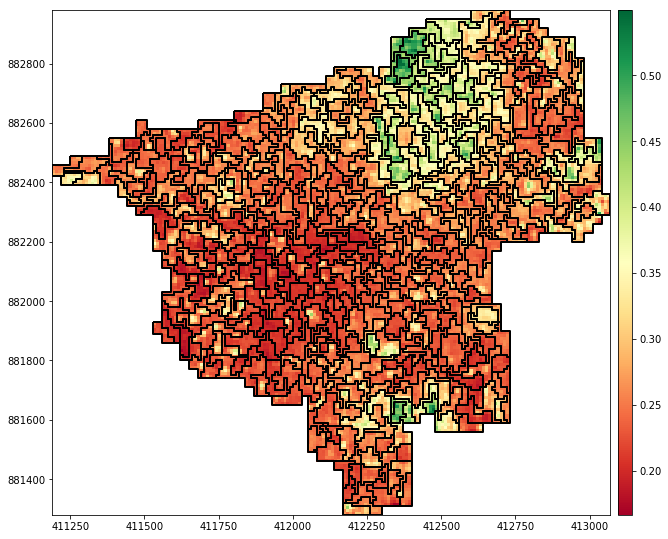

In [7]:
### Open spectral index file with rasterio
im_file = raster_tif
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Plot vector
gdf.plot(facecolor='none', edgecolor='black', linewidth = 2, ax=ax)
# Plot image
color_map = plt.cm.get_cmap("RdYlGn")
src = rasterio.open(im_file, "r")
im_rio = rasterio.plot.show(src, cmap=color_map, ax=ax) 
im_rio = im_rio.get_images()[0]
#vmin=0.153305 et vmax=0.502776
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)
plt.box(False)
plt.savefig('/export/homes/students/rkahn/FIGURES/COMPOSITE_SEGMENTED/NDVI_2019_2021_20pix.png', format='png')

### Display the segmentation over the differents seasons

Raster files timeseries :
/export/homes/students/rkahn/EXPORT/COMPOSITE/NDVI_2019_2021.tif
/export/homes/students/rkahn/EXPORT/COMPOSITE/NDVI_humide_2019_2021.tif
/export/homes/students/rkahn/EXPORT/COMPOSITE/NDVI_seche_2019_2021.tif


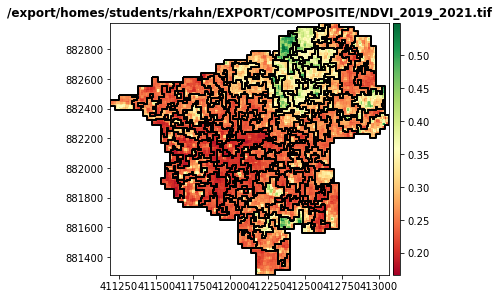

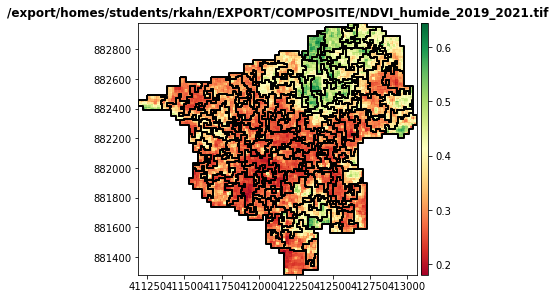

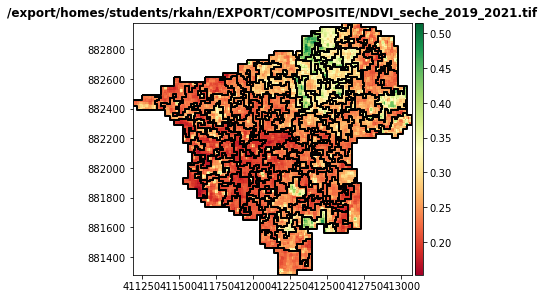

In [72]:
raster_file_list = sorted(glob.glob(f'{composite}*.tif'))
print('Raster files timeseries :')
for raster_file in raster_file_list:
    print(raster_file)
for i in range (len(raster_file_list)):
    src = rasterio.open(raster_file_list[i], "r")
    fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plot vector
    gdf.plot(facecolor='none', edgecolor='black', linewidth = 2, ax=ax)

# Plot image
    color_map = plt.cm.get_cmap("RdYlGn")
    im_rio = rasterio.plot.show(src, cmap=color_map, ax=ax, title=(raster_file_list[i]))
    im_rio = im_rio.get_images()[0]
    
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im_rio, ax=ax, cax=cax)

    plt.box(False)
